<a href="https://colab.research.google.com/github/nagamamo/financial_data_science/blob/main/9_2_fx_asset_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9.2 為替レート決定理論×機械学習

　本例では、アセット・アプローチの理論実装例を示します。ここで示されるのは厳密には、マネタリー・アプローチ・モデルです。まず汎用ライブラリとして、pandas、numpy、datetime、matplotlibを読み込みます。

In [1]:
#[1]汎用ライブラリの読み込み
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

　時系列データを扱う場合、単位根検定を行った上で、アセット・アプローチ理論を実装しなければなりません。単位根検定を実施するためのライブラリは下記をインポートします。

In [7]:
#[2]時系列データ検定ライブラリの読み込み
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #ADF検定用ライブラリ

　機械学習用のライブラリをインポートします。本例では、sklearnを用いて機械学習による実証モデルの性能評価を行い、予測値を算出します。インポートするライブラリには、最小二乗法を行うためのライブラリ、データを学習データとテストデータに分割するライブラリ、決定係数と平均二乗誤差から機械学習評価を行う2つのライブラリの計4つのライブラリをインポートします。

In [2]:
#[3]機械学習用ライブラリの読み込み
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #学習・テストデータ分割のライブラリ
from sklearn.metrics import r2_score #決定係数による評価ライブラリ
from sklearn.metrics import mean_squared_error #平均二乗誤差による評価ライブラリ

　外国為替レート、日米消費者物価指数、日米10年債金利の1990年1月から2024年12月までのデータを取得します。本データの場合は、日時情報”Date”はデータとして利用しませんので、datetimeへ変換してインデックスとして利用します。これによりグラフ作成の際に横軸目盛が自動調整され、目盛文字が重なることがありません。

In [3]:
#[4]データの取得
url = "https://github.com/nagamamo/data/blob/main/9_2_fx_market_data.csv?raw=true"#Git-hubからCSVデータの入手
data = pd.read_csv(url)#データフレームの作成
data["Date"] = pd.to_datetime(data["Date"]) #日時をインデックスの変換のためdatetimeへ変換
US_Japan = data.set_index("Date")#日時をインデックスへ変換

　取得したデータから、ドル円レートの前月比（d_Yen）、日米インフレ率格差（d_P）、日米10年債金利スプレッド(d_R)を算出してpandasデータフレームにそれぞれの新変数列を追加します。この2つの説明変数が、購買力平価要因とマネタリー・アプローチ要因を説明します。重ねて述べるように、sklearnではデータの入出力はnumpy配列を前提としていますので、pandasデータフレームのデータを「.value」により変換し、これをYとXとします。

In [ ]:
#[5]採用変数の算出と定義
US_Japan['d_R']=US_Japan['10USB']-US_Japan['10JPB'] #日米長期金利差の算出
US_Japan['d_P']=US_Japan['P_US']-US_Japan['P_JP'] #日米インフレ率格差の算出
US_Japan['d_Yen']=US_Japan['Yen'].pct_change()*100 #為替レート前月比の算出
US_Japan=US_Japan.dropna()#欠損値の除去
Y=US_Japan['d_Yen'].values #被説明変数の定義と配列変更
X=US_Japan[['d_R','d_P']].values #説明変数の定義と配列変更

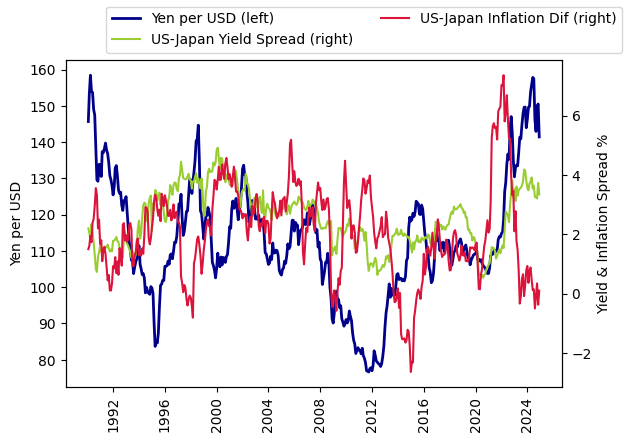

In [5]:
#[6]データの可視化
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(US_Japan['Yen'], lw=2, color="darkblue",label="Yen per USD (left)")
ax2.plot(US_Japan['d_R'], c="yellowgreen",label="US-Japan Yield Spread (right)")
ax2.plot(US_Japan['d_P'], c="crimson",label="US-Japan Inflation Dif (right)")
fig.autofmt_xdate(rotation=90, ha="center")
plt.ylabel('Yen per USD')
ax1.set_ylabel('Yen per USD')
ax2.set_ylabel('Yield & Inflation Spread %')
fig.legend(ncol=2)
plt.show()

　時系列データを用いる場合、時間の経過とともにデータの平均値や分散が変化する単位根を持つか否かを確認した上で、分析を行う必要があります。その理由は、採用するデータがもし時間変化とともに確率分布が変化する非定常過程なのであれば、変数間に誤った関係が存在することを支持してしまう懸念があるためです。この点、データサイエンスでは、例えばある時点tとそれ以前のt-1もしくは更に過去のデータとの関係を示す自己回帰モデルを推計することで、時系列データの定常性（非定常性）を統計的に確認します。これが単位根検定と呼ばれる検定方法です。本例ではstatmodelsの拡張版Dickey=Fuller検定（ADF検定）によりデータの定常性を検定します。本例では、自己回帰モデルにトレンドは含めず、定数項のみと設定しています。
単位根検定の結果は、左から順にADF検定量、p値、検定に用いたラグ数、標本数、1%、5%、10%有意水準を示しています。

In [ ]:
#[7-1]時系列データの単位根検定:為替レート変化率
result1=sm.tsa.stattools.adfuller(US_Japan['d_Yen'],regression='c') #為替レート変化率の単位根検定
print(result1)

In [ ]:
#[7-2]時系列データの単位根検定:米日金利差・インフレ率格差
for col in US_Japan[['d_R', 'd_P']].columns:
    result2 = sm.tsa.stattools.adfuller(US_Japan[col], regression='c')
    print(f"Results for {col}:")
    print(result2)

　データの定常性が確認されれば、データ数と説明変数の配列を念のため確認しておきます。

In [ ]:
#[8]データ数と配列の確認
ndarrayX = np.array(X)
ndarrayY = np.array(Y)
print("ndarrayX.shape:", ndarrayX.shape)
print("ndarrayY.shape:", ndarrayY.shape)

　次にデータを学習データ(X_train、Y_train)とテストデータ（X_test、Y_test）に分割し、学習データにアセット・アプローチ・モデルをフィッティングします。[9]１行目のコードは、学習データとテストデータを、ランダムに70％：30％に分割することを指示しています。2行目のコードで推計に最小二乗法を採用し、3行目において学習データを用いてフィッティングを行います。4行目と5行目は、それぞれ学習データとテストデータを用いた為替レート（変化率）の予測値を算出します。この学習データとテストデータの予測値を比較することで、この実証モデルの性能を評価します。

In [10]:
#[9]アセット・アプローチ・モデルの推計と機械学習
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)#学習データとテストデータの分割
model=LinearRegression(fit_intercept=True,copy_X=True,n_jobs=1,positive=False)#推計方法の定義
model.fit(X_train,Y_train)#フィッティング
Y_train_pred=model.predict(X_train)#学習データによる予測値の算出
Y_test_pred=model.predict(X_test)#テストデータによる予測値の算出

推計結果を出力します。

In [ ]:
#[10]推計結果と可視化
print('d_P coef: %.4f' % model.coef_[0])#係数値
print('d_R coef: %.4f' % model.coef_[1])#係数値
print('R2: %.4f' %model.score(X_train,Y_train))#決定係数

In [ ]:
#[11]データ数と配列の確認
ndarrayX_train = np.array(X_train)
ndarrayY_train= np.array(Y_train)
ndarrayY_train_pred= np.array(Y_train_pred)
print("ndarrayX_train.shape:", ndarrayX_train.shape)
print("ndarrayY_train.shape:", ndarrayY_train.shape)
print("ndarrayY_train_pred.shape:", ndarrayY_train_pred.shape)

　米日インフレ率格差（d_P）、米日長期金利差（d_R）、ドル円レート（d_Yen）の実績値と学習データから算出される理論値をプロットします。

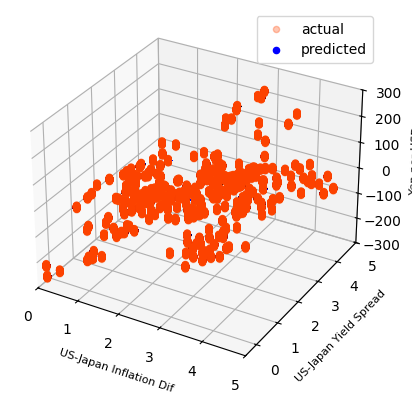

In [16]:
#[12]実績値と予測値のプロット
X_train1, X_train2 = np.split(X_train, 2, 1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train1, X_train2, Y_train,marker="o",alpha=0.3, c='orangered',label='actual')
ax.scatter(X_train1, X_train2, Y_train_pred,marker="o", c='blue',label='predicted')
ax.set_xlabel('US-Japan Inflation Dif',size=8)
ax.set_ylabel('US-Japan Yield Spread',size=8)
ax.set_zlabel('Yen per USD',size=8)
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, 5)
ax.set_zlim(-300, 300)
ax.legend()
plt.show()

In [ ]:
#[12]実績値と予測値のプロット
X_train1, X_train2 = np.split(X_train, 2, 1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train1, X_train2, Y_train,marker="o",alpha=0.3, c='orangered',label='actual')
ax.scatter(X_train1, X_train2, Y_train_pred,marker="o", c='blue',label='predicted')
ax.set_xlabel('US-Japan Inflation Dif',size=8)
ax.set_ylabel('US-Japan Yield Spread',size=8)
ax.set_zlabel('Yen per USD',size=8)
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, 5)
ax.set_zlim(-300, 300)
ax.legend()
plt.show()

In [ ]:
#[13]機械学習の評価
print('RMSE 学習: %.4f, テスト: %.4f' %(np.sqrt(mean_squared_error(Y_train,Y_train_pred)),np.sqrt(mean_squared_error(Y_test,Y_test_pred))))#平方二乗誤差の評価
print('R2 学習: %.4f, テスト: %.4f' %(r2_score(Y_train,Y_train_pred),r2_score(Y_test,Y_test_pred)))#決定係数の評価

　RMSEとR2により、ドル円レート・モデルの性能評価結果を見ると、概ね学習データとテストデータからもたらされる値が接近していることがわかります。最後に、上記の結果を視覚的に確認するため、学習データとテストデータから算出された予測値と実績値との誤差をプロットします。

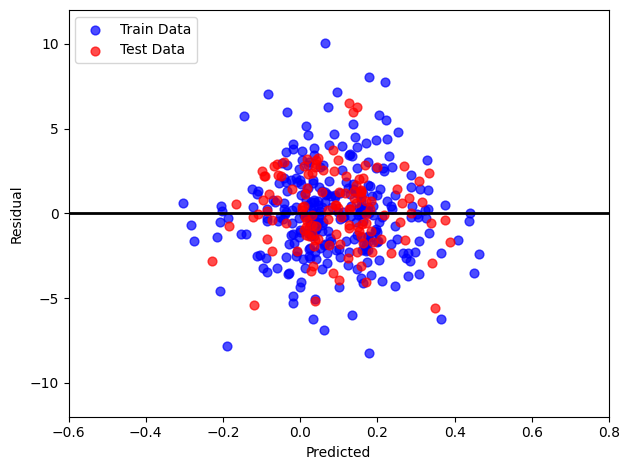

In [14]:
#[14]機械学習結果の可視化
plt.scatter(Y_train_pred,Y_train_pred-Y_train,c='blue',marker='o',s=40,alpha=0.7,label='Train Data')
plt.scatter(Y_test_pred,Y_test_pred-Y_test,c='red',marker='o',s=40,alpha=0.7,label='Test Data')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,lw=2,color='black')
plt.xlim([-0.6,0.8])
plt.ylim([-12,12])
plt.tight_layout()
plt.show()

　最後のセルは、将来のドル円レートを予測するコードです。それぞれlast（直近の米日金利差）、add_spread（未来の金利拡大もしくは縮小幅）、add_CPI（未来の米日インフレ率格差）を入力すれば、その「未来」時点でのドル円レートが計算されます。直近の値は、任意に与えても差し障りありません。米連邦準備制度理事会もしくは日本銀行の金融引き締めによる長期金利差の変化の為替レートへの影響のみを確認したい場合は、add_CPI=0とすると、政策効果のみを演算できます。

In [ ]:
#[15]ドル円レートの予測
lastR=US_Japan.d_R[-1] #標本データ直近の米日金利差
lastP=US_Japan.d_P[-1] #標本データ直近の米日インフレ率格差
add_spread=-2.0 #金利スプレッド拡大幅
add_CPI=0.0 #インフレ率格差拡大幅
spot=143.54 #直近ドル円レート
senario_R=lastR+add_spread
senario_P=lastP+add_CPI
a=model.predict([[senario_P,senario_R]])
spot*(1+a/100)